# COVID-19 Open Research Dataset (CORD-19) Analysis

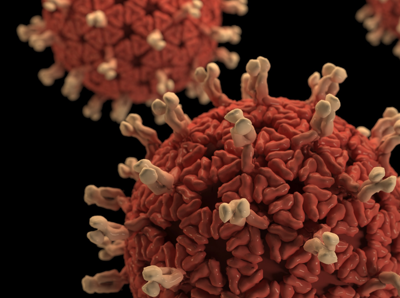


*An example of result snippet is shown below, For each tasks a sperate notebook is created with answers to each questions in a task added to a excel*




**TASK 1:**

**Task Details**
What is known about transmission, incubation, and environmental stability? What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control?*

Specifically, we want to know what the literature reports about:


1. Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
2. Prevalence of asymptomatic shedding and transmission (e.g., particularly children).
3. Seasonality of transmission.
4. Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).
5. Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).
6. Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
7. Natural history of the virus and shedding of it from an infected person
8. Implementation of diagnostics and products to improve clinical processes
9. Disease models, including animal models for infection, disease and transmission
10. Tools and studies to monitor phenotypic change and potential adaptation of the virus
11. Immune response and immunity
12. Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings
13. Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings
14. Role of the environment in transmission

In the above Questions, Questions 1, 3 ,6 ,8 and 13 are attempted using a combination of word2vec embedding to extract the keywords and search algorithm to extract the research articles related to it.

Word2vec embedding provides the keywords that are closest to answer the questions

# SOLUTION APPROACH

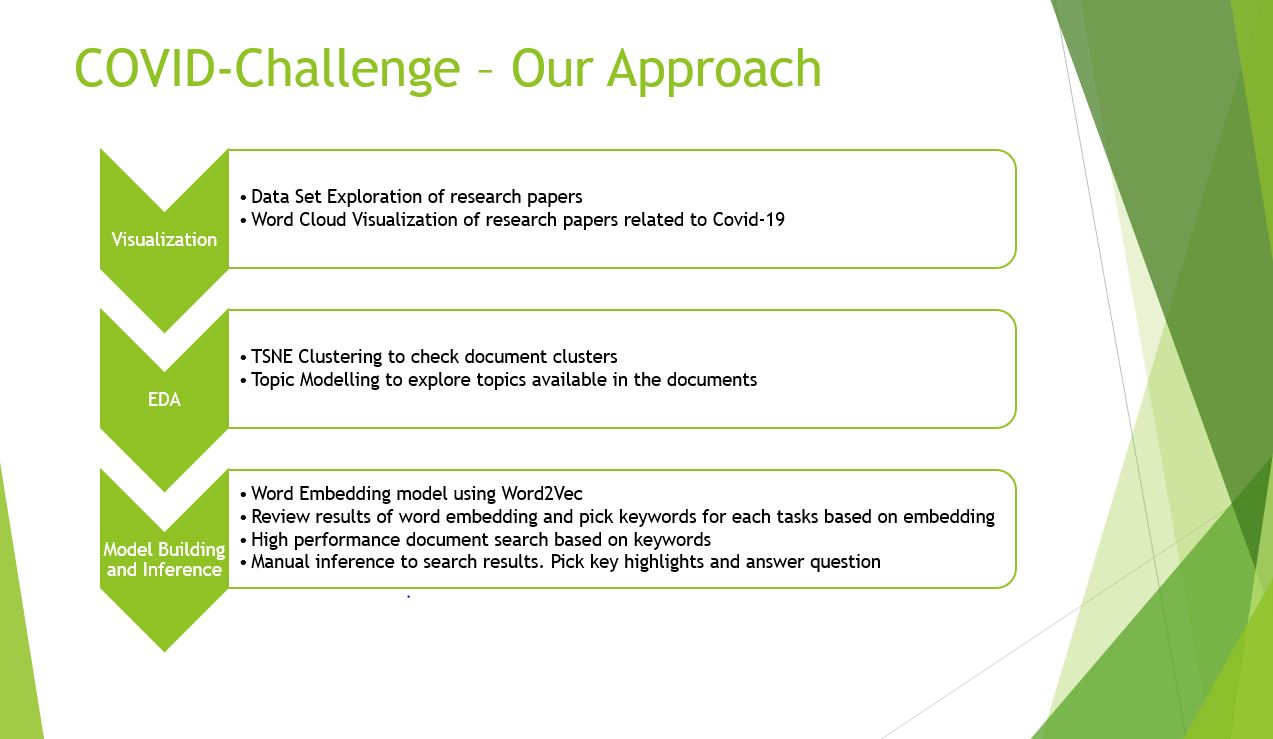

# PROS and CONS

PROS:

1. Good understanding and iference of the research papers through TSNE and LDA models
2. Well Trained word embedding models
3. Accurate keyword extraction with emamples demonstrated with results

CONS:

1. Manual intervention to establish the relationship of search algorithm to derive answers to the questions.

# VISUALIZATION

Import libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import re
import string
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

from time import time
%matplotlib inline
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import spacy.cli
from spacy.matcher import Matcher 
from spacy.matcher import PhraseMatcher

spacy.cli.download("en")
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

Cleaning of corpus helper functions 

In [ ]:
## set english loanguage
stop_words = set(stopwords.words('english'))

## declaration of Porter stemmer.
porter=PorterStemmer()

## Clean Null Record in dataframe
def cleanEmptyData(columnName,df):
    return df[df[columnName].notnull()]

## Remove Punctuation
def remove_punctuation(columnName,df):
    return df.loc[:,columnName].apply(lambda x: re.sub('[^a-zA-z\s]','',x))

## Convert To Lower Case
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str  

## Remove duplicate item in the dataframe
def removeDuplicate(df,list):
    df.drop_duplicates(list, inplace=True)    

## Remove nlp stop words    
def remove_stop_words(columnName,df):
  return df.loc[:,columnName].apply(lambda x: [word for word in x.split() if word not in stop_words])

##Remove single character from the sentence
def remove_one_character_word(columnName,df):
  return df.loc[:,columnName].apply(lambda x: [i for i in x if len(i) > 1])

## Join as a single text with seperator
def join_seperator(columnName,df):
  seperator = ', '
  return df.loc[:,columnName].apply(lambda x: seperator.join(x))

## apply stemmer to data frame fields
def apply_stemmer(columnName,df):
  return df.loc[:,columnName].apply(lambda x: [porter.stem(word) for word in x])

## Data Cleaning Process function
def dataCleaningProcess(dataFrame):
    ## remove duplicate records
    removeDuplicate(dataFrame,['abstract', 'text_body'])
    
    ## clean null value records
    clean_data = cleanEmptyData('text_body',dataFrame)
    clean_data.loc[:,'text_body_clean'] = clean_data.loc[:,'text_body'].apply(lambda x: lower_case(x))
    
    ## removing punctuation 
    clean_data.loc[:,'text_body_clean'] = remove_punctuation('text_body_clean',clean_data)
    
    ## apply stop words
    clean_data.loc[:,'text_body_clean'] = remove_stop_words('text_body_clean',clean_data)
    
    ## apply stemmer for each tokens
    clean_data.loc[:,'text_body_clean'] = apply_stemmer('text_body_clean',clean_data)
    
    ## removing single charter word in the sentence
    clean_data.loc[:,'text_body_clean'] = remove_one_character_word('text_body_clean',clean_data)
    
    ## join as a single text from words token
    clean_data.loc[:,'text_body_clean'] = join_seperator('text_body_clean',clean_data)
    
    ## remove coma after join
    clean_data.loc[:,'text_body_clean'] = remove_punctuation('text_body_clean',clean_data)
    
    return clean_data

Re usable Helper functions

In [ ]:
## get words token from text
def getWordsFromText(_text):
    words = []
    for i in range(0,len(_text)):
        words.append(str(_text.iloc[i]['text_body']).split(" "))
    return words

# Read Excel data as Data Frame
def readExcelToDataFrame(path):
    research_dataframe = pd.read_csv(path,index_col=False)
    research_dataframe.drop(research_dataframe.columns[research_dataframe.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    return research_dataframe

## basic scatter plot
def showScatterPlot(_X,title):
    # sns settings
    sns.set(rc={'figure.figsize':(15,15)})
    # colors
    palette = sns.color_palette("bright", 1)
    # plot
    sns.scatterplot(_X[:,0], _X[:,1], palette=palette)
    plt.title(title)
    # plt.savefig("plots/t-sne_covid19.png")
    plt.show()

## scatter plot with cluster
def showClusterScatterPlot(_X, _y_pred, title):
    # sns settings
    sns.set(rc={'figure.figsize':(10,10)})
    # colors
    palette = sns.color_palette("bright", len(set(_y_pred)))
    # plot
    sns.scatterplot(_X[:,0], _X[:,1], hue=_y_pred, legend='full', palette=palette)
    plt.title(title)
    # plt.savefig("plots/t-sne_covid19_label.png")
    plt.show()


## drop clumns
def getTargetData(dataFrame):
    text_body = dataFrame.drop(["doc_id", "source", "title", "abstract"], axis=1)
    return getWordsFromText(text_body)

## train model for tSNE clustering visualization
def trainEmbededData(_perplexity,dataFrame,total_cluster, _n_iter):
    ## convert text to word frequency vectors
    vectorizer = TfidfVectorizer(max_features=2**12)
    
    ## training the data and returning term-document matrix.
    _X = vectorizer.fit_transform(dataFrame['text_body_clean'].values)
    
    ## tsne declartion
    tsne = TSNE(verbose=1, perplexity=_perplexity,learning_rate=200, random_state=0, n_iter=_n_iter)
    _X_embeded = tsne.fit_transform(_X.toarray())
    
    ## clusterring for tsne
    _kmeans = MiniBatchKMeans(n_clusters=total_cluster)
    return _X_embeded,_kmeans,_X

## predicting cluster centers and predict cluster index for each sample
def predict(_kmeans,_X):
    return _kmeans.fit_predict(_X)

## reusable fucntion for TSNE K-Mean Clustering with TF-IDF
def analyse(pplexity,data_frame,cluster,iter):
    ## train model for tSNE clustering visualization
    embeded,kmeans,x = trainEmbededData(pplexity,data_frame,cluster,iter)
    pred = predict(kmeans,x)
    ## visualized the scatter plot
    showClusterScatterPlot(embeded,pred,'t-SNE Covid-19 - Clustered(K-Means) - Tf-idf with Plain Text')
    return embeded,kmeans,x

**Loading data(a)-Complete data by reading uploaded CSV** | CSV file is created by parsing the JSON data

In [ ]:
research_dataframe = readExcelToDataFrame('/kaggle/input/covid-data/data.csv')
research_dataframe.head()

Data Cleaning

In [ ]:
clean_data =dataCleaningProcess(research_dataframe)

Visualise Cleaned Data and removing columns

In [ ]:
clean_data.head()
clean_process_data = clean_data.drop(["doc_id", "source", "title", "abstract"], axis=1)
clean_process_data.head(20)

Read the meta data from meta_data CSV

In [ ]:
meta_data = readExcelToDataFrame('/kaggle/input/CORD-19-research-challenge/metadata.csv')
meta_data.head()


Data Preparation included the below process:

* Load Research & Meta Data
* Meta Data filter for published time from 2019 to 2020 on doc_id
* Remove unused fields for the search inference.

In [ ]:
def prepare_search_data(_meta_data_frame,research_dataframe):
    ## add a field doc_id
    _meta_data_frame["doc_id"] = _meta_data_frame["sha"]
    
    ## clean NUll record
    _meta_data_frame = cleanEmptyData('doc_id', _meta_data_frame)
    _meta_data_frame = cleanEmptyData('publish_time', _meta_data_frame)
    
    ## select only 2019 & 2020 published records
    meta_data_filter = _meta_data_frame[_meta_data_frame['publish_time'].str.contains('2019') | _meta_data_frame['publish_time'].str.contains('2020')]  
    
     ## clean NUll record
    research_dataframe_clean = cleanEmptyData('doc_id', research_dataframe)
    research_dataframe_clean = cleanEmptyData('text_body', research_dataframe_clean)
    
    ## merging of Research data and meta data on doc_id
    tmp_data_frame  = research_dataframe_clean.merge(meta_data_filter, on='doc_id', how='right')
    
    ## remove un used fields
    clean_process_data = tmp_data_frame.drop(["source", "abstract_x", "cord_uid", "abstract_x","sha","source_x","title_y","pmcid","pubmed_id","license","abstract_y","journal","Microsoft Academic Paper ID","WHO #Covidence","has_pdf_parse","has_pmc_xml_parse","full_text_file"], axis=1)
    
    ## clean NUll record
    clean_process_data = cleanEmptyData('text_body', clean_process_data)
    clean_process_data = clean_process_data.rename(columns={'title_x': 'title'}) 
    
    # reordering the column index
    columns = ["doc_id","doi", "publish_time", "authors","url","title", "text_body"]
    clean_process_data = clean_process_data.reindex(columns=columns)
    
    return clean_process_data

In [ ]:
def process_title(x):
  if not str(x['title_x']).lower() =='nan':
    return str(x['title_x']) + ' (' +  str(x['url']) + ')'
  else:
    return str(x['url'])

Filtered Data to be used to visualize the word cloud in the upcoming cells to understand the importance of topics and vocabs used.

In [ ]:
filter_data = prepare_search_data(meta_data,research_dataframe)
filter_data.head()

# EDA

WORD CLOUD FOR THE TITLE OF ARTICLES FROM 2019 - 2020 

Import libraries 

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt



**WORD CLOUD VISUALIZATION **

We have filtered 2019-2020 research papers to understand COVID-19 data through the word cloud visualization.

In [ ]:
def show_WordCloud(filter_data):
    comment_words = ' '
    stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
    for val in filter_data: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 
        #print(val) 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
         comment_words = comment_words + words + ' '
         #print(comment_words)

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    max_words = 200, 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()



In [ ]:
show_WordCloud(filter_data.title)

The Visualization clearly talks about the : **coronavirus, transmission, infection, vaccine, ourbreak etc.. **
Giving a clear picture of the terminalogies and informations that can be retrived from the research papers.

**Dimensionality Reduction with t-SNE**

Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the text_body_clean can be plotted. t-SNE will attempt to preserve the relations of the higher dimensional data as closely as possible when shrunk to 2D

Analyse with perplexity of 5000, cluster 10, iteration : 15000

The optimal cluster parameter is decided after clustering the data from different preplexity and clusters and visualized.

In [ ]:
embeded,kmeans,x = analyse(5000,clean_process_data,10,15000)

We tried understanding documents with different clusters with various perplexity and identified the optimal perplexity where the convergence of documents took place. 

# MODEL BUILDING AND INFERENCE

LOAD the Research Dataset

In [ ]:
papers = research_dataframe['text_body'].astype('str')
len(papers)
papers.head()
#meta_data_filter = _meta_data_frame[_meta_data_frame['publish_time'].str.contains('2019') | _meta_data_frame['publish_time'].str.contains('2020')]   

We perform some basic text wrangling or preprocessing before diving into topic modeling. We keep things simple here

In [ ]:
%%time
import nltk
import tqdm
nltk.download('wordnet')

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        #if paper_tokens:
        norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

Build a Bi-gram Phrase Model

In [ ]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

In [ ]:
print(bigram_model[norm_papers[1]][:50])

In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Looks like we have a lot of unique phrases in our corpus of research papers, based on the preceding output. Several of these terms are not very useful since they are specific to a paper. Hence, we will prune our vocabulary and start removing terms.

In [ ]:
# Filter out words that occur less than 20 documents, or more than 60% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

**Transforming corpus into bag of words vectors**

We can now perform feature engineering by leveraging a simple Bag of Words model.

In [ ]:
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

In [ ]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

In [ ]:
print('Total number of papers:', len(bow_corpus))

**Topic Models with Latent Dirichlet Allocation (LDA)**

***Building model**

> %%time
> 
> > TOTAL_TOPICS = 10
> 
> lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
>                                    alpha='auto', eta='auto', random_state=42,
>                                    iterations=500, num_topics=TOTAL_TOPICS, 
>                                    passes=20, eval_every=None)*

**Load the LDA Model **

In [ ]:
import joblib
lda_model = joblib.load('/kaggle/input/coviddata/lda_model.jl')

In [ ]:
topics_assigned = lda_model[bow_corpus]

In [ ]:
len(topics_assigned)

In [ ]:
b= pd.DataFrame(topics_assigned,columns = ['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9'])

> TOPIC CSV CREATION

In [ ]:
d= pd.concat([research_dataframe['text_body'],b],axis=1)

EXTRACT CSV

In [ ]:
d.to_csv("Topic_paper_07042020_v4.csv")

**LDA TOPICS WITH TOPIC ID** 

In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=50, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

In [ ]:
import numpy as np
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

**LDA TOPIC WITH WEIGHTS**

In [ ]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

**LDA TOPIC WITHOUT WEIGHTS**

In [ ]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

**Evaluating topic model:**

Quality We can use perplexity and coherence scores as measures to evaluate the topic model. Typically, lower the perplexity, the better the model. Similarly, the lower the UMass score and the higher the Cv score in coherence, the better the model.

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

**Creation of Word Cloud Topic wise**

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=2000,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
with open("/kaggle/input/coviddata/Topic_paper_07042020_v4.csv",encoding = 'utf8', errors='ignore') as f:
    df_topic = pd.read_csv(f)
    
#df = df.replace("\n"," ").dropna()

**WORD CLOUD FOR THE DOMINANT TOPIC(S) **

Example: Topic 1 can have 20 documents while Topic 2 may have 200 documents in it.Hence a word cloud is drawn to visualize the intersting vocabs involving each Topic

**Topic 1**

In [ ]:
show_WordCloud(df_topic.loc[df_topic['Dominant_topic'] == 0]['text_body'])
#show_WordCloud(filter_data.title)

In the above word cloud for the topics were mostly about genome of the covid-19 and possibilties of other corona virus genomes and carriers.


**Topic 2**

In [ ]:
show_WordCloud(df_topic.loc[df_topic['Dominant_topic'] == 1]['text_body'])

> In the above word cloud for the topics were mostly about infection samples and detection of virus in a patient

**Inference of some topics **

* Topic 1&5: mainly deals with the virus structure and genome 
* Topic 3: deals with the origin and history 
* Topic 4&10: For public health risk information 
* Topic 9: Has lab research on various subjects

**WORD2VEC MODEL **

WORD2VEC EMBEDDING IS USED TO PREDICT THE TARGET WORD(S) FORM THE CONTEXT WORDS(Questions from task) USING CBOW 

In this COVID-19 challenge the questions form the context words, we leverage the context words from the questions to predict the target words to form the keywords, which inturn will lead us to the answers for the respective context words(questions). we are using the CBOW approach in word2vec to acheive this.

**Robust Word2Vec Model with Gensim**

The __`gensim`__ framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. We will leverage the same on our covid-19 corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.

- __`size`:__ The word embedding dimensionality : 100
- __`window`:__ The context window size : 20
- __`min_count`:__ The minimum word count : 1
- __`iter`:__ Iteration : 1000 
- __`sg`:__ Training model, 1 for skip-gram otherwise CBOW : CBOW

We have build a  Word2Vec model on the corpus. 

Import libraries

In [ ]:

from __future__ import print_function

__author__ = 'maxim'

import numpy as np
import gensim
import string
from gensim.models import Word2Vec
from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.data_utils import get_file
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import re
import json
import pandas as pd
from gensim.models.fasttext import FastText
from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re

import gensim
import nltk

word2vec model loading, we are using the training model by loading it.

In [ ]:
print('loading model')

word_model = Word2Vec.load("/kaggle/input/covidmodel/word2vec_1000ITR.model")

print('model loaded')

**Model Evaluation:**

Example 1:

**" COVID-19 "** keyword when tested against our word embedding model gave the following results.

[('ncp', 0.7167163491249084), ('wuhan', 0.7067078351974487), ('2019ncov', 0.7065909504890442), ('sarscov2', 0.6876667737960815), ('mers', 0.6260266304016113), ('sars', 0.6118236780166626), ('2020', 0.6101416349411011), ('hubei', 0.5763685703277588), ('mainland', 0.5460340976715088), ('china', 0.531872034072876)]

notable keywords from the word2vec output are: 'wuhan','sars','china' relating to the orgin of the virus


Example 2:

For Multiple keywords **'treatment','option'** keyword when tested against our word embedding model gave the following results.

[('treatments', 0.88392174243927), ('therapies', 0.7969704866409302), ('therapy', 0.7752498984336853), ('drugs', 0.7263898253440857), ('medications', 0.7093261480331421), ('antivirals', 0.6795921325683594), ('regimens', 0.6594418287277222), ('prophylaxis', 0.653971254825592), ('medication', 0.6348516941070557), ('antibiotics', 0.6138178706169128)]

notable keywords from the word2vec outpur are : 'prophylaxis','therapies' relating to preventive medications . 

As shown below:

In [ ]:
print(word_model.most_similar(positive=['covid19'])) 

As shown in the above steps, the context of the context words 'covid19' are well understood by the word2vec model in predicting the target words 'wuhan','sars','china' relating to the orgin of the virus which are very relavant in approaching the answers to the questions. 

In [ ]:
print(word_model.most_similar(positive=['treatment','options' ])) 

As shown in the above steps, the context of the context words 'treatment','options' are well understood by the word2vec model in predicting the target words 'therapy','antivirals','regimens','prophylaxis' which are very relavant in finding the answers to the questions.

**Answering Approach word embedding method**
 
Word embedding for the following questions are extracted by passing a set of words from the question to the word embedding model and closest keywords are extracted to further find the closest keywords as shown in the example below:


1. Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
2. Seasonality of transmission.
3. Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
4. Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings
5. Implementation of diagnostics and products to improve clinical processes

**Example:**

**Question 3 : Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).**

***Embedding Step to extract keywords* **

> print(word_model.predict_output_word(['covid19','surfaces'],topn=30))
> print(word_model.predict_output_word(['covid19','surfaces','nonporous','handrails','desks','floor','fomite'],topn=30))
> print(word_model.most_similar(['covid19','fomites','airborne','nonporous','handrails','desks','floor','fomite'],topn=30))

***Search Algorithm to extracted related research articles:***

> searc_by_keys_as_excel('fomites|airborne|nonporous|handrails|desks|floor|fomite|hands|toilets|door|bedrails',search_data)
> 


In [ ]:

arr_most_similar = [['coronavirus','incubation','period','7day','2day','14day'],['covid19','fomites','airborne','nonporous','handrails','desks','floor','fomite']
      ,['covid19','ppe','masks'],['covid19','diagnostics','tools','advancement','automation'],['covid19','methods','detect','virus']]
arr_predict=[['covid19','season'],['covid19','surfaces','nonporous','handrails','desks','floor','fomite']]     

#Question: 9     
#Public health mitigation measures that could be effective for control
#Intial input fed to word2vec  model to extract related words that could lead to the answers of this question
#['public','health','mitigation','measures',  'effective', 'control','covid19','disease']]
#RESULT from first Query: [('interventions', 0.7447171807289124), ('prevention', 0.7438710927963257), ('preventive', 0.7241473197937012), ('policies', 0.7131460905075073), ('intervention', 0.7103219628334045), ('management', 0.7056314945220947), ('implementing', 0.6939526200294495), ('policy', 0.6897070407867432), ('quarantine', 0.6833001971244812), ('planning', 0.6516326069831848), ('implementation', 0.641217827796936), ('awareness', 0.6297034025192261), ('containment', 0.6278428435325623), ('preparedness', 0.622099757194519), ('epidemic', 0.6220937967300415), ('timely', 0.6204564571380615), ('community', 0.6184203624725342), ('government', 0.6134730577468872), ('outbreak', 0.6104072332382202), ('pandemic', 0.6079082489013672)]]
#Updated input taken from first querying of word2vec model after choosing relevant keywords
#['mitigation','measures','control','covid19','quarantine','containment','awareness','policies']]
#RESULT from second Query: [[('interventions', 0.7805880308151245), ('intervention', 0.7159266471862793), ('policy', 0.690924346446991), ('preventive', 0.6865450143814087), ('implementing', 0.6757345795631409), ('implementation', 0.6531403064727783), ('planning', 0.6507831811904907), ('practices', 0.6400246620178223), ('prevention', 0.6383914947509766), ('management', 0.6378570199012756), ('government', 0.6369956731796265), ('preparedness', 0.6348874568939209), ('restrictions', 0.6139740943908691), ('campaigns', 0.6061151027679443), ('behaviors', 0.5989149808883667), ('plans', 0.5976110696792603), ('decisions', 0.5968020558357239), ('timely', 0.591980516910553), ('governmental', 0.5905696153640747), ('biosecurity', 0.5887465476989746)]]

#Most Similar Keywrods Detection 

len(arr_most_similar)
arrans=[]
print(len(arr_most_similar))
count=0
for i in arr_most_similar:
    print('--------->',i)
    answers=word_model.most_similar(positive=i,topn=30)
    
    arrans.append(answers)
    count +=1
    print('=========',count)
print(arrans)
print(len(arrans))


#Predicted Keywords Detection

arr_predict
len(arr_predict)
arrans_arr_predict=[]
print(len(arr_predict))
count=0
for j in arr_predict:
    print('--------->',j)
    answers1=word_model.predict_output_word(j,topn=30)
    
    arrans_arr_predict.append(answers1)
    count +=1
    print('=========',count)
print(arrans_arr_predict)
print(len(arrans_arr_predict))



**KEYWORDS EXTRACTION:**

Question 1,3,4 and 5:

Keywords sorted using most similar words from the below result 

* Q1- incubation period|2day|7day|14day 
* Q3- fomites|airborne|nonporous|handrails|desks|floor|fomite|hands|toilets|door|bedrails
* Q4- masks|ppe|respirators|protective equipments|gowns|facemasks|effectiveness|n95
* Q5- covid19|diagnostics|tools|advancement|automation|serology

In [ ]:
for q in arrans:
    print(q)

Question 2 and 3:

Keywords sorted using prediction from the below result

* Q2: winter season
* Q3: fomites|airborne|nonporous|handrails|desks|floor|fomite|hands|toilets|door|bedrails

In [ ]:
#arrans
for k in arrans_arr_predict:
    print(k)

**SEARCH ALGORITHM **

To extract the relevant research documents from the keywords extarcted 

In [ ]:
## constant for spliting sentence
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

In [ ]:

 
## spliting to sentence from text
def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

## search inference text by key words and return all the matches sentence
def search_inference_keys(text, keywords):
    sentences = split_into_sentences(text)
    txt = ''
    for sent in sentences:
        r = re.compile(keywords,flags=re.IGNORECASE)
        if len(r.findall(sent))>0:         
            txt = str(txt) + str(sent)
    return txt


## check key words exist or not in a sentence
def check_exist_multiple_keywords(text, keywords):
    r = re.compile(keywords, flags=re.IGNORECASE)
    if len(r.findall(text))>0:    
        return True
    else:
        return False

## Search Inference and download results as excel 
def searc_by_keys_as_excel(keyword, src_data_frame):
    data_frame = src_data_frame
    ## check exist to slice down the related contents
    data_frame['search_key_status'] =data_frame.loc[:,'text_body'].apply(lambda x: check_exist_multiple_keywords(x,keyword))
    ## select only target data
    process_data_frame = data_frame.query('search_key_status == True')
  
    ## filter on corona and covid 19 related data
    process_data_frame['search_covid_content'] =process_data_frame.loc[:,'text_body'].apply(lambda x: check_exist_multiple_keywords(x,'covid-19|sars-cov-2|2019-ncov|ncov-19|coronavirus'))
  
    ## get only covid-19|sars-cov-2|2019-ncov|ncov-19|coronavirus data
    process_data_frame = process_data_frame.query('search_covid_content == True')
    process_data_frame.loc[:,'inference'] = process_data_frame.loc[:,'text_body'].apply( lambda x: search_inference_keys(x,keyword))
    
    ## remove unused fields
    final_data = process_data_frame.drop(["search_key_status","text_body"], axis=1)
    ## download as excel
    final_data.to_excel(str(keyword) + '_result.xlsx', sheet_name='keyword')
  
    return final_data

In [ ]:
# Search Inference for "incubation period" and download results as excel 
search_data = prepare_search_data(meta_data,research_dataframe)

*The Keywords extracted through embedding are passed on to the below functions to extarct the list of research articles to further manually pick the articles relevant to the questions to answer the questions.*

**Following are the keywords picked question wise:**

* Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
**--> incubation period|2day|7day|14day**
* Seasonality of transmission.
**--> winter season**
* Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
**--> fomites|airborne|nonporous|handrails|desks|floor|fomite|hands|toilets|door|bedrails**
* Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings
**--> masks|ppe|respirators|protective equipments|gowns|facemasks|effectiveness|n95**
* Implementation of diagnostics and products to improve clinical processes
**--> covid19|diagnostics|tools|advancement|automation|serology**


Seperate Excel is created in the Output section for each questions with its possible research articles that can prove the inference made using the word2vec answering approach.

Question 1: -->**Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery. --> incubation period|2day|7day|14day****

In [ ]:
final_data =searc_by_keys_as_excel('incubation period|2day|7day|14day',search_data)


final_data.head()

Question 2: --> Seasonality of transmission. --> winter season

In [ ]:
final_data =searc_by_keys_as_excel('winter season',search_data)


Question 3: --> Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic). --> fomites|airborne|nonporous|handrails|desks|floor|fomite|hands|toilets|door|bedrails

In [ ]:
final_data =searc_by_keys_as_excel('fomites|airborne|nonporous|handrails|desks|floor|fomite|hands|toilets|door|bedrails',search_data)

Question 4: --> Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings --> masks|ppe|respirators|protective equipments|gowns|facemasks|effectiveness|n95

In [ ]:
final_data =searc_by_keys_as_excel('masks|ppe|respirators|protective equipments|gowns|facemasks|effectiveness|n95',search_data)

Question 5: --> Implementation of diagnostics and products to improve clinical processes --> covid19|diagnostics|tools|advancement|automation|serology

In [ ]:
final_data =searc_by_keys_as_excel('covid19|diagnostics|tools|advancement|automation|serology',search_data)

# CONCLUSION

1. **Incubation Period :**

Key HighLight in Search

* Mean Incubation Period is 5days across various papers
* Range of Incubation Period is upto 14 days
* Median Incubation Period is reported to be 3 days
* There are evidences where incubation period is mentioned as 20 days

1. Mean Incubation Period is 5days across various papers

2019-11-07 AlRuthia, Yazed; Somily, Ali M; Alkhamali, Amal S; Bahari, Ohud H; AlJuhani, Raneem J; Alsenaidy, Mohammad; Balkhi, Bander https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6844224/ Estimation Of Direct Medical Costs Of Middle East Respiratory Syndrome Coronavirus Infection: A Single-Center Retrospective Chart Review Study

After an average incubation period of approximately 5 days, 8 patients typically present with symptoms of lower respiratory tract infection, such as cough and shortness of breath often combined with nonspecific signs of the disease, such as fatigue, myalgia, fever, rhinorrhea, headaches, sore throat, vomiting, or diarrhea.

2020 Wu, Yi-Chi; Chen, Ching-Sung; Chan, Yu-Jiun https://doi.org/10.1097/jcma.0000000000000270 The outbreak of COVID-19: An overview COVID-19 has a mean incubation period of 5.Clinicians should consider the possibility of 2019-nCoV virus infection in persons with travel or exposure history with compatible incubation period and presenting symptoms.

2020-02-05 Julie Spencer; Deborah P Shutt; Sarah K Moser; Hannah Clegg; Helen J Wearing; Harshini Mukundan; Carrie A Manore https://doi.org/10.1101/2020.02.04.20020404 Epidemiological parameter review and comparative dynamics of influenza, respiratory syncytial virus, rhinovirus, human coronavirus, and adenovirus

Results of our review for human coronavirus include the following mean values: an incubation period of 5.We assume here that the latent period equals the incubation period, or the mean period of time between exposure to the virus and the onset of symptoms.Second, the assumption that the latent period equals the incubation period may result in an overestimation of the latent period.This is because the beginning of the true infectious period may occur before the onset of symptoms; however, this is difficult to measure and is not generally reported in the studies that report values for the incubation period.Incubation periods of acute respiratory viral infections: a systematic review.

2. Range of Incubation Period is upto 14 days

2020-01-28 Natalie M. Linton; Tetsuro Kobayashi; Yichi Yang; Katsuma Hayashi; Andrei R. Akhmetzhanov; Sung-mok Jung; Baoyin Yuan; Ryo Kinoshita; Hiroshi Nishiura https://doi.org/10.1101/2020.01.26.20018754 Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data

The incubation period is defined as the time from infection to illness onset.Knowledge of the incubation period of a directly transmitted infectious disease is critical to determine the time period required for monitoring and restricting the movement of healthy individuals (i.e., the quarantine period) [5, 6] .The incubation period also aids in understanding the relative infectiousness of COVID-19 and can be used to estimate the epidemic size [7] .Using publicly available data from the ongoing epidemic of COVID-19 with known event dates, the present study aimed to estimate the incubation period and other time intervals that govern the interpretation of epidemiological dynamics of COVID-19 infections.We thus estimated the incubation period by (i) excluding Wuhan residents and (ii) including Wuhan residents.We used the dates of three critical points in the course of infection-symptom onset, hospital admission, and death-to calculate four time intervals: the time from (a) exposure to illness onset (i.e., incubation period), (b) illness onset to hospital admission, (c) illness onset to death, and (d) hospital admission to death.) is the PDF of the incubation period independent of g(.To address the selection bias in the dataset due to the continued growth of the outbreak (i.e., cases with shorter incubation periods are more likely to be included in the dataset), we also accounted for .For the incubation period estimates, the lognormal distribution provided the best fit to the data, both when excluding and including Wuhan residents.The mean incubation period was estimated at 5.The mean incubation period was 5.Figure 2 shows the cumulative distribution function of the incubation period with and without right truncation.The present study advances the public discussion on COVID-19 infections by presenting explicit estimations of the incubation period and other epidemiologic characteristics using publicly available data.Our estimated mean incubation period of approximately 5 days is comparable to known mean values of the incubation period for severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS) [9, [16] [17] [18] , as well as other recent estimates of the incubation period for COVID-19 [18] .In addition to empirically showing the comparability of COVID-19 to other disease-causing coronaviruses, the present study has also shown that the 95th percentile of the incubation period is around 10-14 days, indicating that a 14-day quarantine period would largely ensure the absence of disease among healthy .[18] noted a similar finding in their analysis of the incubation period for 88 cases (including 63 Wuhan residents).From the 95th percentile estimate of the incubation period we found that the length of quarantine should be at least 14 days, and we stress that the 17-24-day time delay from illness onset to death must be addressed when estimating COVID-19 case fatality risk.

2020-02-11 Lin, Xiaoqi; Gong, Zhenyu; Xiao, Zuke; Xiong, Jingliang; Fan, Bing; Liu, Jiaqi https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7039714/

The incubation period of 2019-nCoV is generally 3-7 days but no longer than 14 days, and the virus is infective during the incubation period.

3. Median Incubation Period is reported to be 3 days

2020 Xu, Xiao-Wei; Wu, Xiao-Xin; Jiang, Xian-Gao; Xu, Kai-Jin; Ying, Ling-Jun; Ma, Chun-Lian; Li, Shi-Bo; Wang, Hua-Ying; Zhang, Sheng; Gao, Hai-Nv; Sheng, Ji-Fang; Cai, Hong-Liu; Qiu, Yun-Qing; Li, Lan-Juan https://doi.org/10.1136/bmj.m606 Clinical findings in a group of patients infected with the 2019 novel coronavirus (SARS-Cov-2) outside of Wuhan, China: retrospective case series

The incubation period was defined as the time from exposure to the onset of illness, which was estimated among patients who could provide the exact date of close contact with individuals from Wuhan with confirmed or suspected SARS-Cov-2 infection.Among 56 patients who could provide the exact date of close contact with someone with confirmed or suspected SARS-Cov-2 infection, the median incubation period from exposure to symptoms was 4 days (interquartile range 3-5 days).Among the 33 patients who had symptoms for more than 10 days after illness onset, the median incubation period from exposure to symptoms was 3 days (interquartile range 3-4 days).It is possible that an even greater number of infected patients exist without a diagnosis because their symptoms were less severe and because of the incubation period.

2020-02-29 Shi Zhao; Peihua Cao; Daozhou Gao; Zian Zhuang; Marc Chong; Yongli Cai; Jinjun Ran; Kai Wang; Yijun Lou; Weiming Wang; Lin Yang; Daihai He; Maggie H Wang https://doi.org/10.1101/2020.02.26.20028449 Title: Modelling the coronavirus disease (COVID-19) outbreak on the Diamond Princess ship using

Note that a recent study on the 1099 patients found that the median of incubation period is only 3 days, thus a short effective SI is also possible [15] .

There are evidences where incubation period is mentioned as 20 days 10.1101/2020.02.19.20025023 2020-02-23 Jinwei Ai; Junwen Chen; Yong Wang; Xiaoyun Liu; Wufeng Fan; Gaojing Qu; Meiling Zhang; Shengduo Polo Pei; Bowen Tang; Shuai Yuan; Yang Li; Lisha Wang; Guoxin Huang; Bin Pei https://doi.org/10.1101/2020.02.19.20025023 participated in study designimage.png
In the analysis of 44 cases with clear contact time, incubation periods ranged from one to twenty days with a mean of 8.In our analysis of 44 patients with clear contact history, we found that the mean incubation period of COVID-19 was 8.Compared with previous studies [9, 10] , the incubation period of our patients varied more greatly with maximum of 20 days.The prolonged incubation period will increase the risk of virus transmission.The rate of severe illness and death were low, whereas some patients had longer incubation period.

print(word_model.predict_output_word(['covid19','season'],topn=20))

2. **Seasonality of Transmission :**

Key Point

Corona Viruses show seasonal transmission during various pandemic occured before. A detailed study is available in the below paper. However, Covid-19 is not yet proven the seasonality as it has affected even tropical climates in Singapore. Hence it is not yet seasonal. It can be observed in the future global transmission.

2020-02-17 Richard A Neher; Robert Dyrdak; Valentin Druelle; Emma B Hodcroft; Jan Albert https://doi.org/10.1101/2020.02.13.20022806 Potential impact of seasonal forcing on a SARS-CoV-2 pandemic

1.Seasonal forcing on SARS-CoV-2 should thus be taken into account in the further monitoring of the global transmission 2.The seasonal CoVs show a strong and consistent seasonal variation, and modeling suggests that this requires strong variation in transmissibility throughout the year. It should be noted, however, that SARS-CoV-2 does seem to transmit in tropical climates like Singapore, and so winter is not a necessary condition of SARS-CoV-2 spread

3. **Transmission Surfaces :**

Covid-19 looks to be airborne generating from the aerosols in medical procedure of patients There are evidences that the toilets and ICUs are tested positive for airborne in hospitals Studies suspect that there are possibilities are virus shedding through stools for patients with diahrea

Covid-19 looks to be airborne generating from the aerosols in medical procedure of patients.
2020 Peng, Xian; Xu, Xin; Li, Yuqing; Cheng, Lei; Zhou, Xuedong; Ren, Biao https://doi.org/10.1038/s41368-020-0075-9 Transmission routes of 2019-nCoV and controls in dental practice

Studies have suggested that 2019-nCoV may be airborne through aerosols formed during medical procedures 46 .Since 2019-nCoV can be passed directly from person to person by respiratory droplets, emerging evidence suggested that it may also be transmitted through contact and fomites 43, 48 .The pathogenic microorganisms can be transmitted in dental settings through inhalation of airborne microorganisms that can remain suspended in the air for long periods 51 , direct contact with blood, oral fluids, or other patient materials 52 , contact of conjunctival, nasal, or oral mucosa with droplets and aerosols containing microorganisms generated from an infected individual and propelled a short distance by coughing and talking without a mask 53, 54 , and indirect contact with contaminated instruments and/or environmental surfaces 50 .The airborne spread of SARS-Cov (severe acute respiratory syndrome coronavirus) is well-reported in many literatures.Particles of droplets and aerosols are small enough to stay airborne for an extended period before they settle on environmental surfaces or enter the respiratory tract.Specifically, the oral professionals should wash their hands before patient examination, before dental procedures, after touching the patient, after touching the surroundings and equipment without disinfection, and after touching the oral mucosa, damaged skin or wound, blood, body fluid, secretion, and excreta.Since airborne droplet transmission of infection is considered as the main route of spread, particularly in dental clinics and hospitals, barrier-protection equipment, including protective eyewear, masks, gloves, caps, face shields, and protective outwear, is strongly recommended for all healthcare givers in the clinic/hospital settings during the epidemic period of 2019-nCoV.It has been reported that the use of rubber dam could significantly reduce airborne particles in~3-foot diameter of the operational field by 70% 58 .We have summarized the possible transmission routes of 2019-nCov in stomatology, such as the airborne spread, contact spread, and contaminated surface spread.

There are evidences that the toilets and ICUs are tested positive for airborne in hospitals

2020-03-10 Yuan Liu; Zhi Ning; Yu Chen; Ming Guo; Yingle Liu; Nirmal Kumar Gali; Li Sun; Yusen Duan; Jing Cai; Dane Westerdahl; Xinjin Liu; Kin-fai Ho; Haidong Kan; Qingyan Fu; Ke Lan https://doi.org/10.1101/2020.03.08.982637 Aerodynamic Characteristics and RNA Concentration of SARS-CoV-2 Aerosol in Wuhan Hospitals during COVID-19 Outbreak

Generally undetectable or very low concentrations of airborne SARS-CoV-2 were found in most PAA inside the two hospitals in Wuhan.The negative pressure ventilation and high air exchange rate inside ICU, CCU and ward room of Renmin Hospital are effective in minimizing airborne SARS-CoV-2.This study also recorded an elevated airborne SARS-CoV-2 concentration inside the patient mobile toilet of Fangcang Hospital.has found the wipe samples from room surfaces of toilets used by SARS-CoV-2 patients tested positive.

Studies suspect that there are possibilities are virus shedding through stools for patients with diahrea 2020-03-08 Roman Woelfel; Victor Max Corman; Wolfgang Guggemos; Michael Seilmaier; Sabine Zange; Marcel A Mueller; Daniela Niemeyer; Patrick Vollmar; Camilla Rothe; Michael Hoelscher; Tobias Bleicker; Sebastian Bruenink; Julia Schneider; Rosina Ehmann; Katrin Zwirglmaier; Christian Drosten; Clemens Wendtner https://doi.org/10.1101/2020.03.05.20030502 Virological assessment of hospitalized cases of coronavirus disease 2019 *equal contribution **senior authors with equal contribution

The present study shows that COVID-19 can often present as a common cold-like illness. SARS-CoV-2 can actively replicate in the upper respiratory tract, and is shed for a prolonged time after symptoms end, including in stool

4. **Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings Effectiveness of Personal Protective Equipments.: **

Personal Protective Equipments have proven very effective in the control of Covid-19 in China. The below article and study retrieved through our keywords indicates there was a model derived which has proved the usage of self-protection equipments as effective.

2020-03-06 Hui Wan; Jing-an Cui; Guo-Jing Yang https://doi.org/10.1101/2020.03.01.20029629 Risk estimation and prediction by modeling the transmission of the novel coronavirus (COVID-19) in mainland China excluding Hubei province

**Results**: The estimation outcomes indicate that the control reproduction number is 3.36 (95% CI 3.20-3.64) and Re(t) has dropped below 1 since January 31st, 2020, which implies that the containment strategies implemented by the Chinese government in mainland China excluding Hubei province are indeed effective and magnificently suppressed COVID-19 transmission. Moreover, our results show that relieving personal protection too early may lead to the spread of disease for a longer time and more people would be infected, and may even cause epidemic or outbreak again. By calculating the effective reproduction ratio, we prove that the contact rate should be kept at least less than 30% of the normal level by April, 2020. Conclusions: To ensure the epidemic ending rapidly, it is necessary to maintain the current integrated restrict interventions and self-protection measures, including travel restriction, quarantine of entry, contact tracing followed by quarantine and isolation and reduction of contact, like wearing masks, etc. People should be fully aware of the real-time epidemic situation and keep sufficient personal protection until April. If all the above conditions are met, the outbreak is expected to be ended by April in mainland China apart from Hubei province